<a href="https://colab.research.google.com/github/jash-ai/PYTHON/blob/main/Stock_Trading_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.analyticsvidhya.com/blog/2023/10/building-and-validating-simple-stock-trading-algorithms-using-python/

Building and Validating Simple Stock Trading Algorithms Using Python

In [ ]:
!pip install yfinance
!pip install pandas-ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=113679382e1afa8353ae4fe6d69032d9dcc120f13d76ec3e5f4ce003600c6c0d
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [ ]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
from datetime import timedelta as delta
import numpy as np
import os
import seaborn as s

Extracting the Historical Stock Prices Using yfinance

In [6]:
##file get produced called WIPRO.CSV
def get_stock_info(stock, save_to_disk=False):
    start_date = '2000-01-01'
    end_date = (dt.now() + delta(1)).strftime('%Y-%m-%d')
    df = yf.download(f"{stock}.NS", period='1d', start=start_date, end=end_date, progress=False)
    if(save_to_disk == True):
        path = './csv'
        try: os.mkdir(path)
        except OSError as error: pass
        df.to_csv(f'{path}/{stock}.csv')
        ##df.to_csv(c'{path}/{stock}.csv')
    return df

df = get_stock_info('WIPRO', save_to_disk = True)

Building Stock Trading Algorithms Using Technical Indicators

https://www.investopedia.com/terms/m/macd.asp


SMA stands for Simple Moving Average while
MACD stands for Moving Average Convergence Divergence.

For the SMA crossover, we will take the 10-day, 30-day, 50-day, and 200-day moving averages into account. For the MACD crossover, we will take the 12-day, 26-day, and 9-day exponential moving averages into account. Let’s calculate these values using the pandas_ta library

For calculating the SMA, we will use the “sma()” function by passing the adjusted close price of the stock along with the number of days. For calculating the MACD, we will use the “macd()” function by passing the adjusted close price of the stock and setting the fast, slow, and signal parameters as 12, 26, and 9 respectively. The SMA and MACD values don’t make a lot of sense as such. So, let’s encode them to understand if there are any crossovers

In the case of SMA, we will take 3 conditions:
The 10-day SMA should be above the 30-day SMA.
The 10-day and 30-day SMA should be above the 50-day SMA.
The 10-day, 30-day, and 50-day should be above the 200-day SMA.
In the case of MACD, we will have 2 conditions:
The MACD should be above the MACD signal.
The MACD should be greater than 0.
The Python code given below creates a function to implement the conditions mentioned above.

In [7]:
def add_signal_indicators(df):
    df['SMA_10'] = ta.sma(df['Adj Close'],length=10)
    df['SMA_30'] = ta.sma(df['Adj Close'],length=30)
    df['SMA_50'] = ta.sma(df['Adj Close'],length=50)
    df['SMA_200'] = ta.sma(df['Adj Close'],length=200)

    macd = ta.macd(df['Adj Close'], fast=12, slow=26, signal=9)
    df['MACD'] = macd['MACD_12_26_9']
    df['MACD_signal'] = macd['MACDs_12_26_9']
    df['MACD_hist'] = macd['MACDh_12_26_9']

    df['10_cross_30'] = np.where(df['SMA_10'] > df['SMA_30'], 1, 0)

    df['MACD_Signal_MACD'] = np.where(df['MACD_signal'] < df['MACD'], 1, 0)

    df['MACD_lim'] = np.where(df['MACD']>0, 1, 0)

    df['abv_50'] = np.where((df['SMA_30']>df['SMA_50'])
            &(df['SMA_10']>df['SMA_50']), 1, 0)

    df['abv_200'] = np.where((df['SMA_30']>df['SMA_200'])
            &(df['SMA_10']>df['SMA_200'])&(df['SMA_50']>df['SMA_200']), 1, 0)

    return df

df =  add_signal_indicators(df)

Now that we have all the signals added to our data, it is time to calculate the returns. The returns will be the most important aspect for selecting the best trading strategy amongst the lot. We will calculate the 5-day and 10-day returns of the stock. We will also label encode the returns as 0 and 1 with 0 indicating negative returns and 1 indicating positive returns. Let’s go ahead and create the function implementing the same.

In [9]:
def calculate_returns(df):
    df['5D_returns'] = (df['Adj Close'].shift(-5)-df['Adj Close'])/df['Close']*100
    df['10D_returns'] = (df['Adj Close'].shift(-10)-df['Adj Close'])/df['Close']*100

    df['5D_positive'] = np.where(df['5D_returns']>0, 1, 0)
    df['10D_positive'] = np.where(df['10D_returns']>0, 1, 0)

    return df.dropna()

In [10]:
df = calculate_returns(df)

In [11]:
df


,Open,High,Low,Close,Adj Close,Volume,SMA_10,SMA_30,SMA_50,SMA_200,...,MACD_hist,10_cross_30,MACD_Signal_MACD,MACD_lim,abv_50,abv_200,5D_returns,10D_returns,5D_positive,10D_positive
Date,,,,,,,,,,,,,,,,,,,,,
2000-10-06,98.446877,98.446877,94.912506,97.805626,79.794716,10832239,81.861690,90.433568,85.179279,112.005841,...,-0.601153,0,0,0,0,0,-13.475762,-9.806515,0,0
2000-10-09,96.384377,98.056877,94.237503,94.798126,77.341049,8544212,80.988372,89.899695,85.250655,111.975863,...,-0.654693,0,0,0,0,0,-10.098251,-11.834568,0,0
2000-10-10,96.000008,96.180000,90.375008,91.413757,74.579910,11238852,80.199342,89.218359,85.272072,111.898744,...,-0.810231,0,0,0,0,0,-10.987546,-8.229759,0,0
2000-10-11,88.312508,88.871254,84.414375,85.700630,69.918854,12785066,78.866039,88.212314,85.177137,111.790984,...,-1.140947,0,0,0,0,0,-13.226509,-0.178484,0,0
2000-10-12,84.425629,88.875008,82.312508,87.283127,71.209946,14328852,77.878298,87.259911,85.147552,111.698529,...,-1.181672,0,0,0,0,0,-4.663650,-1.381065,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-28,416.500000,416.500000,404.000000,405.350006,405.350006,8438058,423.915002,421.650003,416.596001,395.893290,...,-3.641899,1,0,0,1,1,0.616751,1.406188,1,1
2023-09-29,405.000000,409.250000,401.500000,406.049988,406.049988,6390136,420.875000,421.266670,416.358000,395.958131,...,-3.802386,0,0,0,1,1,-0.110819,1.022048,0,1
2023-10-03,406.450012,408.100006,403.600006,405.450012,405.450012,2864052,417.315002,421.058336,416.114001,396.008500,...,-3.761103,0,0,0,1,1,0.567268,1.467501,1,1


Understanding the Performance of the Signals

We can take all the conditions mentioned above and perform a simple aggregate to calculate the average and the median returns we can expect while trading based on these signals. We can also extract the minimum and the maximum returns each signal has generated in the past. This will not only give us a rough understanding of how good the signals are but also an idea of how much returns can be expected while trading using these signals. Let’s write a simple code to do the same using Python.

In [12]:
def get_eda_and_deepdive(df):
    eda = df.dropna().groupby(['10_cross_30', 'MACD_Signal_MACD',
    'MACD_lim', 'abv_50', 'abv_200'])[['5D_returns', '10D_returns']]\
    .agg(['count', 'mean','median', 'min', 'max'])

    deepdive = df.dropna().groupby(['10_cross_30', 'MACD_Signal_MACD',
     'MACD_lim', 'abv_50', 'abv_200','5D_positive', '10D_positive'])[['5D_returns', '10D_returns']]\
    .agg(['count', 'mean','median', 'min', 'max'])

    return eda, deepdive


eda, deepdive = get_eda_and_deepdive(df)

Let’s visualize the box whiskers plot for the top 10 signal combinations sorted based on the 5-day and the 10-day returns.

In [13]:
x = df.copy()

def _fun(x):
    code = ''
    for i in x.keys(): code += str(x[i])
    return code

x['signal'] = x[['10_cross_30', 'MACD_Signal_MACD', 'MACD_lim', 'abv_50', 'abv_200',
                     '5D_positive', '10D_positive']].apply(_fun, axis=1)

x = x.dropna()

lim = x.groupby(['10_cross_30', 'MACD_Signal_MACD', 'MACD_lim',
'abv_50', 'abv_200', '5D_positive', '10D_positive'])['5D_returns'].agg(['mean']).reset_index()
lim = lim.sort_values(by='mean', ascending=False).head(10)

x = x.merge(lim, on=['10_cross_30', 'MACD_Signal_MACD', 'MACD_lim',
 'abv_50', 'abv_200', '5D_positive', '10D_positive'], how='inner')

In [15]:
import seaborn as sb

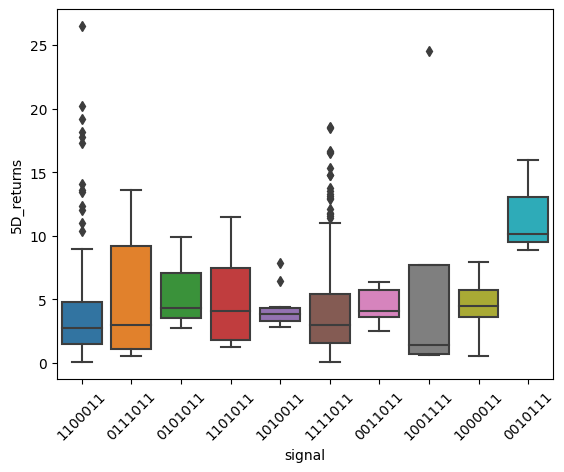

In [16]:
ax = sb.boxplot(x='signal', y='5D_returns', data=x)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

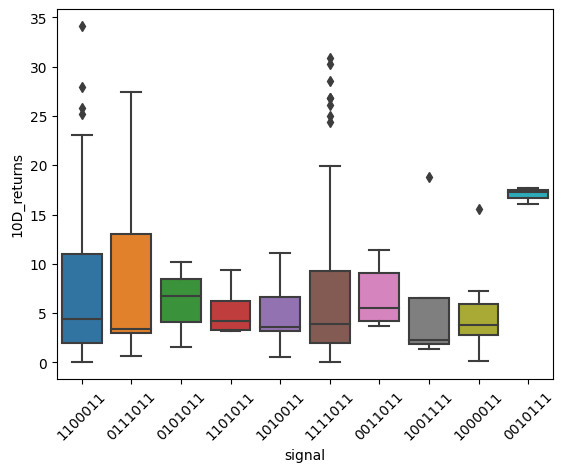

In [17]:
ax = sb.boxplot(x='signal', y='10D_returns', data=x)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

Taking only the 5-day and 10-day returns for selecting the best signals is not the best approach because we will never know how many times the signal has given positive returns against negative returns. This approach could be taken into account while selecting the best strategies, which could potentially improve the performance of the strategies. I will not take this approach to keep this article simple and beginner-friendly.